In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import glob
import matplotlib.pyplot as plt

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch 
import os
import torch
from torch.utils.data import DataLoader
import hashlib
import json
import shutil
import sys

sys.path.append("src")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project')

from data_class import SongDataSet_Image, CollateFunction
from model import TweetyBERT
from analysis import plot_umap_projection
from utils import detailed_count_parameters, load_torch_model


# programatically load last saved weight
weights_gpt_2_style = '/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/experiments/100k_steps_llb3/saved_weights/model_step_99990.pth'
config_gpt_2_style = '/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/experiments/100k_steps_llb3/config.json'

## new model ###
with open(config_gpt_2_style, 'r') as f:
    config = json.load(f)  # Load and parse the JSON file

 # Data Loading
collate_fn = CollateFunction(segment_length=config['context'])
train_dataset = SongDataSet_Image("/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/umap_eval_dataset_llb16", num_classes=config['num_clusters'], subsampling=True, subsample_factor=config['subsample'], remove_silences=config['remove_silences'])
test_dataset = SongDataSet_Image("/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/umap_eval_dataset_llb16", num_classes=config['num_clusters'], subsampling=True, subsample_factor=config['subsample'], remove_silences=config['remove_silences'])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, num_workers=16)

# Initialize model
model = TweetyBERT(
    d_transformer=config['d_transformer'], 
    nhead_transformer=config['nhead_transformer'],
    embedding_dim=config['embedding_dim'],
    num_labels=config['num_clusters'],
    tau=None,
    dropout=config['dropout'],
    dim_feedforward=config['dim_feedforward'],
    transformer_layers=config['transformer_layers'],
    m=config['m'],
    p=config['p'],
    alpha=config['alpha'],
    sigma=config['sigma']
).to(device)

detailed_count_parameters(model)
load_torch_model(dir=weights_gpt_2_style, model=model)


Total Trainable Parameters: 13,467,330


In [34]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class SongDataSet_Image(Dataset):
    def __init__(self, file_dir, num_classes=21, segment_length=370):
        self.file_path = []
        self.num_classes = num_classes
        self.segment_length = segment_length

        for file in os.listdir(file_dir):
            self.file_path.append(os.path.join(file_dir, file))

    def __getitem__(self, index):
        file_path = self.file_path[index]
        data = np.load(file_path, allow_pickle=True)
        spectogram = data['s']

        spectogram = spectogram[20:216,:]

        ground_truth_labels = data['labels']

        # Z-score normalization
        mean_val = spectogram.mean()
        std_val = spectogram.std()
        spectogram = (spectogram - mean_val) / (std_val + 1e-7)  # Adding a small constant to prevent division by zero
        
        # Replace NaN values with zeros
        spectogram[np.isnan(spectogram)] = 0

        # Convert to tensor
        spectogram = torch.from_numpy(spectogram).float().permute(1, 0)  # Bringing spectrogram to length x height


        ground_truth_labels = torch.tensor(ground_truth_labels, dtype=torch.int64).squeeze(0)

        # Convert label to one-hot encoding
        ground_truth_labels = F.one_hot(ground_truth_labels, num_classes=self.num_classes).float()

        return spectogram, ground_truth_labels 

    def __len__(self):
        return len(self.file_path)

class CollateFunction:
    def __init__(self, segment_length=5000):
        self.segment_length = segment_length

    def __call__(self, batch):
        # Unzip the batch (a list of (spectrogram, ground_truth_labels) tuples)
        spectrograms, ground_truth_labels = zip(*batch)

        # Create lists to hold the processed tensors
        spectrograms_processed = []
        ground_truth_labels_processed = []

        # Each sample in batch
        for spectrogram, ground_truth_label in zip(spectrograms, ground_truth_labels):
            # Truncate if larger than context window or take random window
            if spectrogram.shape[0] > self.segment_length:
                start = torch.randint(0, spectrogram.shape[0] - self.segment_length, (1,)).item()
                end = start + self.segment_length
                spectrogram = spectrogram[start:end]
                ground_truth_label = ground_truth_label[start:end]
            elif spectrogram.shape[0] < self.segment_length:
                # Pad with 0s if shorter
                pad_amount = self.segment_length - spectrogram.shape[0]
                spectrogram = F.pad(spectrogram, (0, 0, 0, pad_amount), 'constant', 0)
                ground_truth_label = F.pad(ground_truth_label, (0, 0, 0, pad_amount), 'constant', 0)

            # Append the processed tensors to the lists
            spectrograms_processed.append(spectrogram)
            ground_truth_labels_processed.append(ground_truth_label)

        # Stack tensors along a new dimension
        spectrograms = torch.stack(spectrograms_processed, dim=0)
        ground_truth_labels = torch.stack(ground_truth_labels_processed, dim=0)

        # Final reshape for model
        spectrograms = spectrograms.unsqueeze(1).permute(0, 1, 3, 2)

        return spectrograms, ground_truth_labels

In [35]:
from torch.utils.data import DataLoader

train_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/train"
test_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/test"

train_dataset = SongDataSet_Image(train_dir)
test_dataset = SongDataSet_Image(test_dir)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


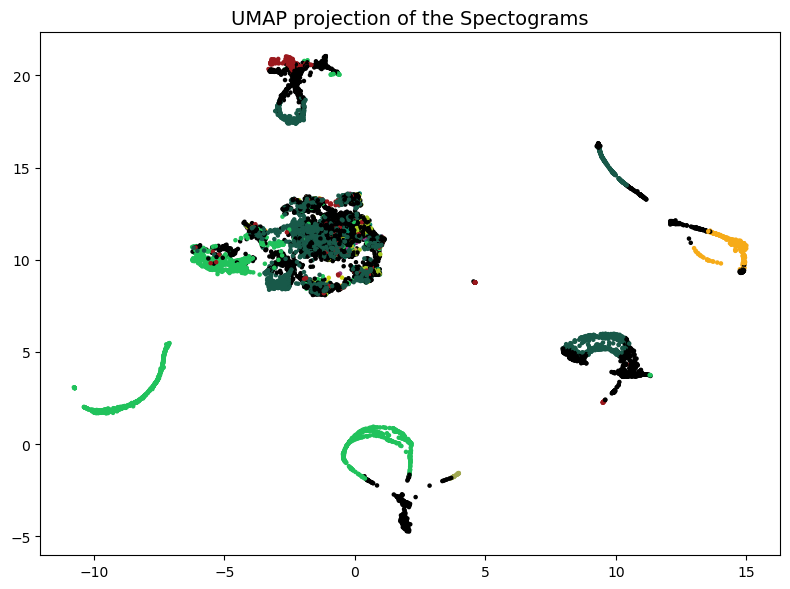

: 

In [49]:
import pickle 
import umap

def eucledian_distance_with_temporal_distance():
    

    pass


list_of_data = []
list_of_ground_truth = []

for i,  (data, ground_truth_label) in enumerate(test_loader):
   
    ground_truth_label = ground_truth_label.argmax(-1)
    data = data.cpu().numpy()
    ground_truth_label = ground_truth_label.cpu().numpy()
    ground_truth_label = ground_truth_label.reshape(-1,1)

    data = torch.Tensor(data)

    output, layers = model.inference_forward(data.to(device))
    layer_output_dict = layers[-1]
    data = layer_output_dict.get("intermediate_residual_stream", None)
    data = data.reshape(-1,1 * 512)
    
    list_of_data.append(data.detach().cpu().numpy())
    list_of_ground_truth.append(ground_truth_label)

    if i >= 10:
        break

# list_of_data = list_of_data[:5000]
# list_of_ground_truth = list_of_ground_truth[:5000]


list_of_data = np.concatenate(list_of_data, axis=0)
list_of_ground_truth = np.concatenate(list_of_ground_truth, axis=0)

# color stuff #
file_path = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/category_colors_llb3.pkl"
with open(file_path, 'rb') as file:
    color_map_data = pickle.load(file)

label_to_color = {label: tuple(color) for label, color in color_map_data.items()}

colors_for_points = []
for label_row in list_of_ground_truth:
    if label_row.ndim > 0:
        # If label_row is iterable (more than one dimension)
        row_colors = [label_to_color[int(lbl)] for lbl in label_row]
        avg_color = np.mean(row_colors, axis=0)
    else:
        # If label_row is a single integer (one dimension)
        avg_color = label_to_color[int(label_row)]
    colors_for_points.append(avg_color)


reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.05, n_components=2, metric='euclidean')
embedding_outputs = reducer.fit_transform(list_of_data)

# Create the plot
fig = plt.figure(figsize=(8, 6))
plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=5, c=colors_for_points)
plt.title(f'UMAP projection of the Spectograms', fontsize=14)
plt.tight_layout()
plt.show()
